# Predict Temporal Series

In [1]:
import addutils.toc ; addutils.toc.js(ipy_notebook=True)

In [2]:
import scipy.io
import numpy as np
import pandas as pd
from addutils import css_notebook
css_notebook()

## 1 Predict Univariate Temporal Data

This is the simpler case in temporal data prediction: we have just one measure to predict. The easier task is to made a one-step prediction. Here we test different ensamble methods on a multi-step prediction.

Here for simplicity we consider data sampled with a constant sample time. in this way, when we speak about time, it can be either time or the number of the sample.
At every time-step the system will have an output **y(t)** and our goal is to predict the future output nk steps forward **y(t+nk)**.

To fit the regressor we built a vector of **nk+1** past data samples: **[y(t-nk), ... , y(t-2), y(t-1), y(t)]**. Past measured values that build the regressor vector are referred as **Standard Regressor Components**. Is instead we define the values in the form of arbitrary user-defined functions of delayed input variables we call it **Custom Regressor Components**. In this case we will use just Standard Regressor Components.

Usually predicting something many timesteps in advance is very hard: here we want to test the predictive capabilitied of many different ensemble regressors by predicting 9 timesteps in the future.

Hint: try to change nb (the regressor vector length) to see how this affect the prediction

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt


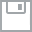
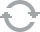
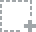
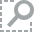
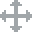
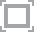
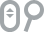
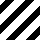
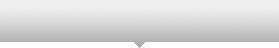
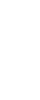
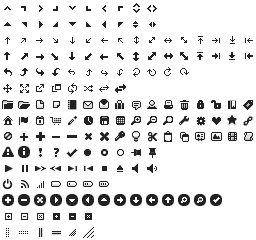
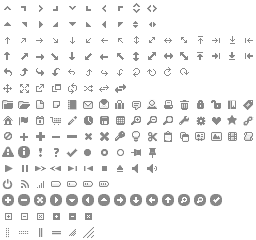
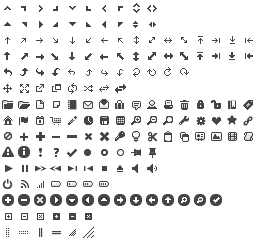
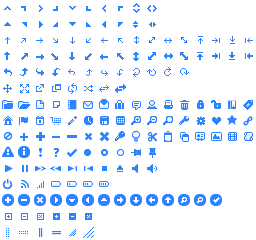
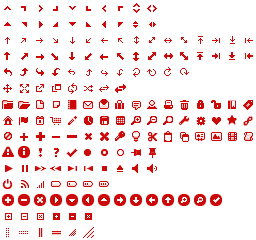
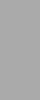
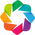
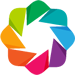

In [12]:
import bokeh.plotting as bk
bk.output_notebook()

In [13]:
import warnings
from time import time
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.set_option('display.max_columns', None,
              'display.float_format', '{:,.3f}'.format)

In [19]:
n_samples = 700
error = 0.02
df = pd.DataFrame(np.zeros((n_samples,3)), columns=['t', 'y(t)', 'y_true'])
df['t'] = np.linspace(0, 6, n_samples)
df['y_true'] = np.sin(2*df['t']) + 0.88*np.cos(11 * df['t']) + \
               0.3*np.sin(29*df['t']) + 0.1*np.sin(47*df['t'])
df['y(t)'] = df['y_true'] + np.random.normal(0, error, n_samples)

nb = 40 # Number of past input terms used to predict the current output.
nk =  9 # Samples delayed from input to output (prediction time steps)

for i in range(1,nb+1):
    col_name = 'y(t-%i)' %(i,)
    df.insert(1, col_name, df['y(t)'].shift(i))
col_to_predict = 'y(t+%i)' %(nk,)
df[col_to_predict] = df['y(t)'].shift(-nk)

first_row, last_row = nb, df.shape[0]-(nk+1)
X = df[df.columns[1:nb+2]].ix[first_row:last_row]
y = df[col_to_predict].ix[first_row:last_row]

In [20]:
from sklearn import datasets, cross_validation, ensemble, metrics, grid_search
param_rfr = {'n_estimators': [25, 50],
             'max_depth': [15],
             'min_samples_split' : [1, 2, 4],
             'min_samples_leaf' : [2],
             'bootstrap' : [True]}

param_xtr = {'n_estimators':[25, 50],
             'max_features':[2, 3, 4],
             'max_depth':[10, 15, 20],
             'min_samples_split':[1, 2, 4],
             'min_samples_leaf':[2],
             'bootstrap':[True]}

param_adb = {'n_estimators':[75, 150],
             'learning_rate':[0.5, 1.0]}

param_gtb = {'n_estimators':[50, 100],
             'learning_rate':[0.2, 0.5],
             'subsample':[0.5, 1.0],
             'max_depth':[1, 2]}

# Fit the Random Forest Regressor
t0 = time()
rfr = grid_search.GridSearchCV(ensemble.RandomForestRegressor(), 
                               param_rfr, cv=15, verbose=0, n_jobs=-1).fit(X, y)
print '\nRFR Fitted in %0.3f[s]' %(time() - t0)
rfr_best = rfr.best_estimator_
rfr_pred = rfr_best.predict(X)
print rfr_best
df['y RFR'] = float('nan')
df['y RFR'][first_row:last_row+1] = rfr_pred

# Fit the Extra Trees Regressor
t0 = time()
xtr = grid_search.GridSearchCV(ensemble.ExtraTreesRegressor(), 
                               param_xtr, cv=15, verbose=0, n_jobs=-1).fit(X, y)
print '\n\nXTR Fitted in %0.3f[s]' %(time() - t0)
xtr_best = xtr.best_estimator_
xtr_pred = xtr_best.predict(X)
print xtr_best
df['y XTR'] = float('nan')
df['y XTR'][first_row:last_row+1] = xtr_pred

# Fit the AdaBoost Regressor
t0 = time()
adb = grid_search.GridSearchCV(ensemble.AdaBoostRegressor(), 
                               param_adb, cv=15, verbose=0, n_jobs=-1).fit(X, y)
print '\n\nADB Fitted in %0.3f[s]' %(time() - t0)
adb_best = adb.best_estimator_
adb_pred = adb_best.predict(X)
print adb_best
df['y ADB'] = float('nan')
df['y ADB'][first_row:last_row+1] = adb_pred

# Fit the Gradient Tree Boosting
t0 = time()
gtb = grid_search.GridSearchCV(ensemble.GradientBoostingRegressor(), 
                               param_gtb, cv=15, verbose=0, n_jobs=-1).fit(X, y)
print '\nGTB Fitted in %0.3f[s]' %(time() - t0)
gtb_best = gtb.best_estimator_
gtb_pred = gtb_best.predict(X)
print gtb_best
df['y GTB'] = float('nan')
df['y GTB'][first_row:last_row+1] = gtb_pred



RFR Fitted in 30.535[s]
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


XTR Fitted in 19.119[s]
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=15,
          max_features=4, max_leaf_nodes=None, min_samples_leaf=2,
          min_samples_split=1, min_weight_fraction_leaf=0.0,
          n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)


ADB Fitted in 35.402[s]
AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=150, random_state=None)

GTB Fitted in 30.404[s]
GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.2, loss='ls',
             max_depth=1, max_features=None, max_leaf_nodes=None,
          

In [21]:
fig1 = bk.figure(plot_width=700, plot_height=400, 
                 title='Prediction with nb=%i past input terms' % nb)
fig1.title_text_font_size = '11pt'
fig1.line(df['t'], df['y_true'].shift(-nk), color='black', 
          alpha=0.8, legend='Ground Truth')
fig1.circle(df['t'], df[col_to_predict], color='black', 
            alpha=0.5, legend='Measured', size=3)
fig1.line(df['t'], df['y RFR'], color='green', 
          alpha=1.0, legend='RFR %s'%(col_to_predict,))
fig1.line(df['t'], df['y XTR'], color='red', 
          alpha=0.4, legend='XTR %s'%(col_to_predict,))
fig1.line(df['t'], df['y ADB'], color='blue', 
          alpha=0.4, legend='ADB %s'%(col_to_predict,))
fig1.line(df['t'], df['y GTB'], color='magenta', 
          alpha=0.8, legend='GTB %s'%(col_to_predict,))

fig2 = bk.figure(plot_width=700, plot_height=400,
                 title='Prediction Error with nb=%i past input terms' % nb)
fig2.title_text_font_size = '11pt'
fig2.line(df['t'], df[col_to_predict]-df[col_to_predict], color='black', 
          alpha=0.5, legend='Measured')
fig2.line(df['t'], df['y RFR']-df[col_to_predict], color='green', 
          alpha=1.0, legend='RFR %s'%(col_to_predict,))
fig2.line(df['t'], df['y XTR']-df[col_to_predict], color='red', 
          alpha=0.6, legend='XTR %s'%(col_to_predict,))
fig2.line(df['t'], df['y ADB']-df[col_to_predict], color='blue', 
          alpha=0.3, legend='ADB %s'%(col_to_predict,))
fig2.line(df['t'], df['y GTB']-df[col_to_predict], color='magenta', 
          alpha=0.3, legend='GTB %s'%(col_to_predict,))
fig2.legend.orientation = 'bottom_right'

bk.show(bk.gridplot([[fig1], [fig2]]))


## 2 Compute the Features Importance

Here we see how a very shallow Decision Tree (a Random forest with just one tree) is able to discover the most important features in presence of strong measurement noise. We generate a sinusoidal signal with a period of 15 samples and fit the tree to predict one step in advance using 22 hystorical steps in the regressor. Even in presence of noise, the tree correctly find the signal periodicity by selecting the features y(t-7) and y(t-15) as the most important in the regressor.

Hint: try to change error, n_estimators and cv values to see how the model behaves. 

In [47]:
import matplotlib.gridspec as gridspec
t = np.arange(0.0, 30.0*np.pi, np.pi/50.0)
error = 0.1
df = pd.DataFrame(np.zeros((t.shape[0],3)), columns=['t', 'y(t)', 'y_true'])

df['t'] = t
df['y_true'] = np.sin(2*np.pi*df['t'])
df['y(t)'] = df['y_true'] + np.random.normal(0, error, t.shape[0])
nb = 22 # Number of past input terms used to predict the current output.
nk =  1 # Samples delayed from input to output (prediction time steps)

for i in range(1,nb+1):
    col_name = 'y(t-%i)' %(i,)
    df.insert(1, col_name, df['y(t)'].shift(i))
col_to_predict = 'y(t+%i)' %(nk,)
df[col_to_predict] = df['y(t)'].shift(-nk)

first_row, last_row = nb, df.shape[0]-(nk+1)
X = df[df.columns[1:nb+2]].ix[first_row:last_row]
y = df[col_to_predict].ix[first_row:last_row]

param_rfr1 = {'n_estimators': [1],
              'max_depth': [2],
              'min_samples_split' : [2],
              'min_samples_leaf' : [1],
              'bootstrap' : [True]}

# Fit the Random Forest Regressor
t0 = time()
rfr = grid_search.GridSearchCV(ensemble.RandomForestRegressor(), 
                               param_rfr1, cv=31, verbose=0, n_jobs=-1).fit(X, y)
print '\nRFR Fitted in %0.3f[s]' %(time() - t0)
rfr_best = rfr.best_estimator_
rfr_pred = rfr_best.predict(X)
print rfr_best
df['y RFR2'] = float('nan')
df['y RFR2'][first_row:last_row+1] = rfr_pred

feature_importance_raw = rfr_best.feature_importances_
feature_importance = 100.0 * (feature_importance_raw/feature_importance_raw.max())
feature_importance_sorted_idx = np.argsort(feature_importance)
cols = list(X.columns[feature_importance_sorted_idx])

fig1 = bk.figure(plot_width=700, plot_height=250,
                 title='Prediction with nb=%i past input terms' % nb)
fig1.title_text_font_size = '11pt'
fig1.legend.orientation = 'bottom_right'
fig1.line(df['t'], df['y_true'].shift(-nk), color='red', 
          alpha=0.8, legend='Ground Truth')
fig1.line(df['t'], df['y RFR2'], color='green', 
          alpha=1.0, legend='RFR %s'%(col_to_predict,))
fig1.circle(df['t'], df[col_to_predict], size=3, color='black', 
            alpha=0.5, legend='Measured')

fig2 = bk.figure(plot_width=700, plot_height=250, 
                 title='Prediction Error with nb=%i past input terms' % nb)
fig2.title_text_font_size = '10pt'
fig2.line(df['t'], df[col_to_predict]-df[col_to_predict], color='black', 
          alpha=0.5, line_width=1.5, legend='Measured')
fig2.line(df['t'], df['y RFR2']-df[col_to_predict], color='green', 
          alpha=1.0, legend='RFR %s'%(col_to_predict,))

fig3 = bk.figure(plot_width=700, plot_height=700, title='Features Importance', 
                 y_range=cols, x_range=(0,100))
fig3.title_text_font_size = '10pt'
fig3.xaxis.axis_label = 'Relative Importance'
fig3.xaxis.axis_label_text_font_size = '10pt'
fig3.segment(0, cols, feature_importance[feature_importance_sorted_idx], 
             cols, line_width=25)

bk.show(bk.gridplot([[fig1], [fig2], [fig3]]))


RFR Fitted in 0.411[s]
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


---

Visit [www.add-for.com](<http://www.add-for.com/IT>) for more tutorials and updates.

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.